In [1]:
#!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
from tensorflow.keras import Sequential,Model,Input
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPool2D, Conv2DTranspose, Cropping2D
from tensorflow.keras.layers import Add, Dropout, Permute, add
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers, backend #Adam
import matplotlib.pyplot as plt
%load_ext tensorboard
from tensorboard import notebook
import datetime,os
import numpy as np

from data_processing import prepare_data
from metrics.intersection_over_union import iou

# Model Architecture

![Fast-SCNN Architecture](https://github.com/DeepVoltaire/Fast-SCNN/raw/master/figures/fast-scnn.png)

#### Custom function for conv2d: conv_block

In [2]:
def conv_block(inputs, conv_type, kernel, kernel_size, strides, padding='same', relu=True):
  
    if(conv_type == 'ds'):
        x = tf.keras.layers.SeparableConv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)
    else:
        x = tf.keras.layers.Conv2D(kernel, kernel_size, padding=padding, strides = strides)(inputs)  

    x = tf.keras.layers.BatchNormalization()(x)

    if (relu):
        x = tf.keras.activations.relu(x)
  
    return x

## Step 1: Learning to DownSample

In [3]:
# Input Layer
input_layer = tf.keras.layers.Input(shape=(256, 256, 3), name = 'input_layer', batch_size=16)

In [4]:
lds_layer = conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = conv_block(lds_layer, 'conv', 64, (3, 3), strides = (1, 1))
lds_layer = conv_block(lds_layer, 'conv', 96, (3, 3), strides = (1, 1))
# lds_layer = conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
# lds_layer = conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

## Step 2: Global Feature Extractor

#### residual custom method

In [5]:
def _res_bottleneck(inputs, filters, kernel, t, s, r=False):
    
    tchannel = tf.keras.backend.int_shape(inputs)[-1] * t

    x = conv_block(inputs, 'conv', tchannel, (1, 1), strides=(1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.activations.relu(x)

    x = conv_block(x, 'conv', filters, (1, 1), strides=(1, 1), padding='same', relu=False)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x

#### Bottleneck custom method

In [6]:
def bottleneck_block(inputs, filters, kernel, t, strides, n):
    x = _res_bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _res_bottleneck(x, filters, kernel, t, 1, True)

    return x

#### PPM Method

In [7]:
def pyramid_pooling_block(input_tensor, bin_sizes):
    concat_list = [input_tensor]
#   w = 64
#   h = 32
    w = 32
    h = 32

    for bin_size in bin_sizes:
        x = tf.keras.layers.AveragePooling2D(pool_size=(w//bin_size, h//bin_size), strides=(w//bin_size, h//bin_size))(input_tensor)
        x = tf.keras.layers.Conv2D(128, 3, 2, padding='same')(x)
        x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (w,h)))(x)
        concat_list.append(x)

    return tf.keras.layers.concatenate(concat_list)

#### Assembling all the methods

In [8]:
gfe_layer = bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)
gfe_layer = pyramid_pooling_block(gfe_layer, [2,4,6,8])

## Step 3: Feature Fusion

In [9]:
ff_layer1 = conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

In [10]:
ff_layer2 = tf.keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = tf.keras.layers.DepthwiseConv2D((3,3), strides=(1, 1), depth_multiplier=1, padding='same')(ff_layer2)
ff_layer2 = tf.keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = tf.keras.activations.relu(ff_layer2)
ff_layer2 = tf.keras.layers.Conv2D(128, 1, 1, padding='same', activation=None)(ff_layer2)

In [11]:
ff_final = tf.keras.layers.add([ff_layer1, ff_layer2])
ff_final = tf.keras.layers.BatchNormalization()(ff_final)
ff_final = tf.keras.activations.relu(ff_final)

## Step 4: Classifier

In [12]:
classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

classifier = tf.keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = tf.keras.layers.BatchNormalization()(classifier)
classifier = tf.keras.activations.relu(classifier)

num_of_classes=2
classifier = conv_block(classifier, 'conv', num_of_classes, (1, 1), strides=(1, 1), padding='same', relu=False)

classifier = tf.keras.layers.Dropout(0.3)(classifier)

classifier = tf.keras.layers.UpSampling2D((2, 2))(classifier)
classifier = tf.keras.activations.softmax(classifier)

## Model Compilation

In [13]:
fast_scnn = tf.keras.Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')
fast_scnn.compile(optimizer = optimizers.Adam(lr = 0.001), loss="categorical_crossentropy", metrics=[iou, 'accuracy'])

In [14]:
fast_scnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(16, 256, 256, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (16, 128, 128, 32)   896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (16, 128, 128, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(16, 128, 128, 32)] 0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [ ]:
# tf.keras.utils.plot_model(fast_scnn, show_layer_names=True, show_shapes=True)
tb = TensorBoard(log_dir='training_logs/test_log1', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='trained_models/test1.h5', monitor='iou', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=50, verbose=1)
callbacks = [tb, mc, es]
num_epochs=20
fast_scnn.fit(prepare_data.train_data_generator(batch_size=16), steps_per_epoch=246 ,
                validation_data = prepare_data.validation_data_generator(batch_size=16), 
                validation_steps = 84, epochs=num_epochs, callbacks=callbacks, verbose=1)

In [ ]:
fast_scnn.load_weights('trained_models/fast_scnn_2.h5')
result=fast_scnn.evaluate(prepare_data.test_data_generator(batch_size=16),steps=85)
print(result)

Found 1360 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.


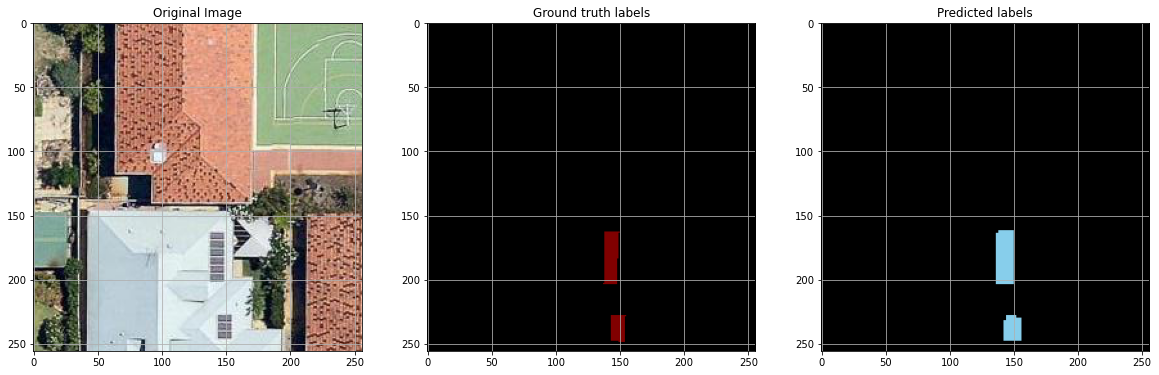

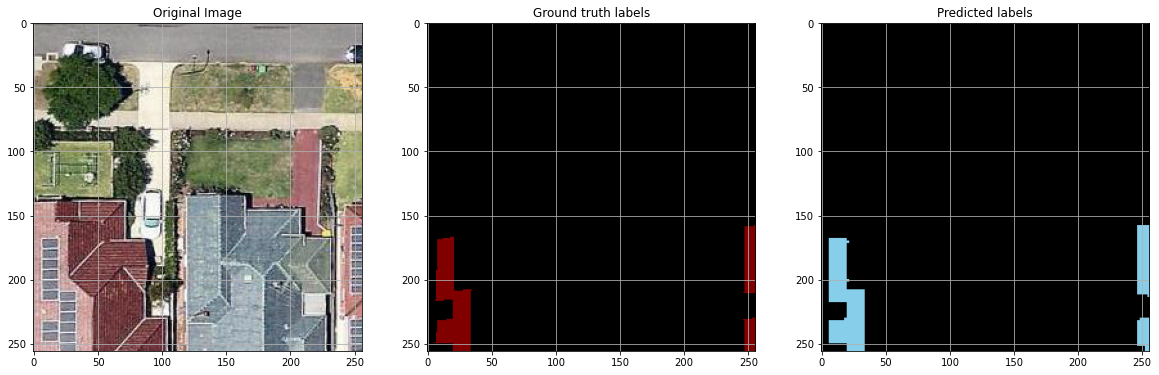

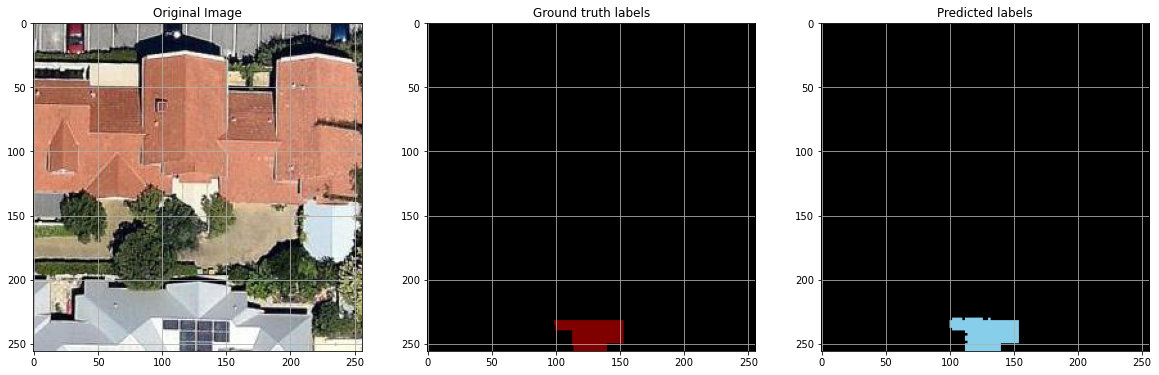

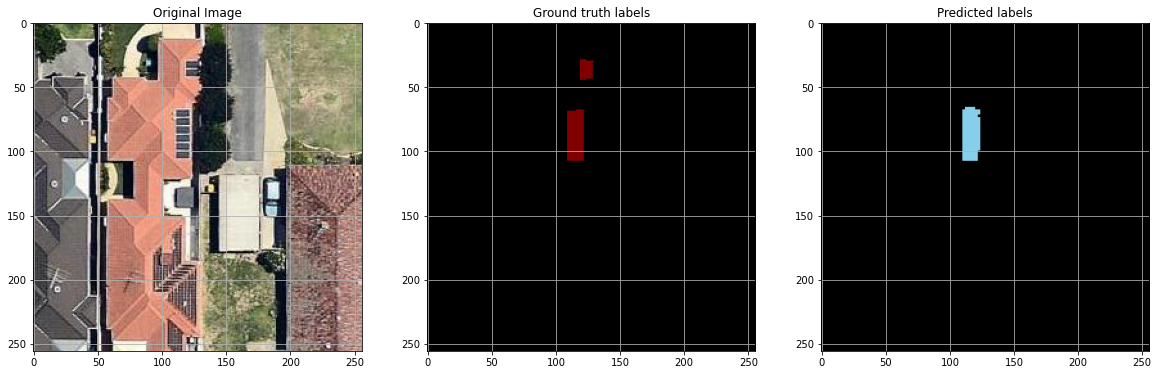

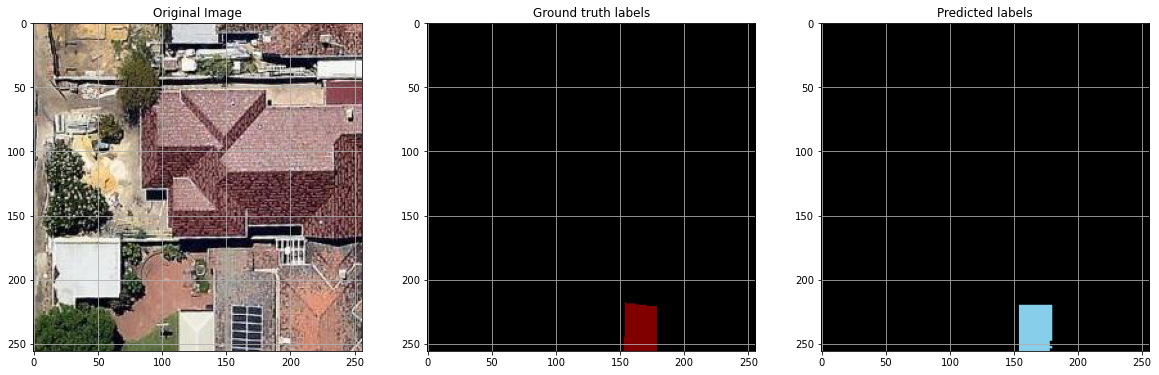

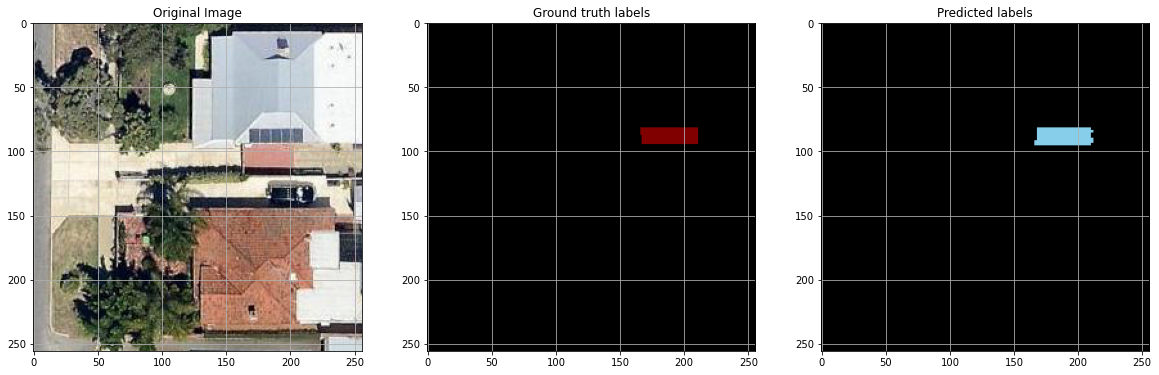

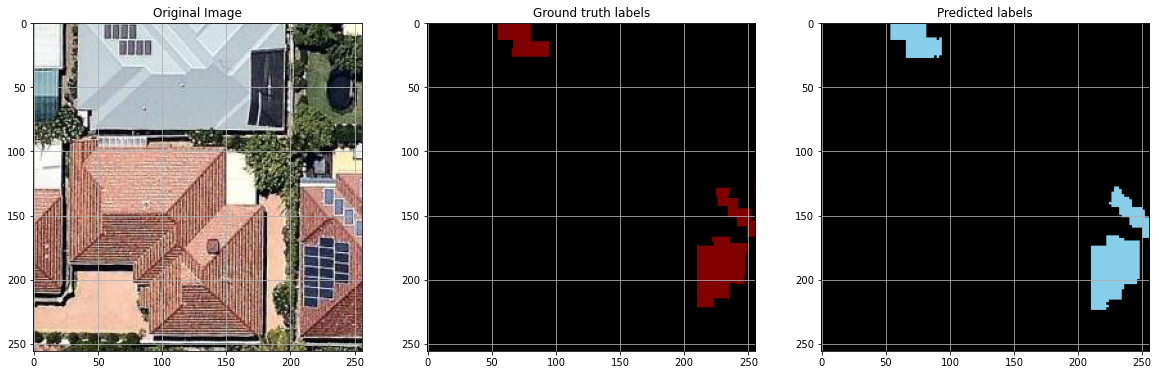

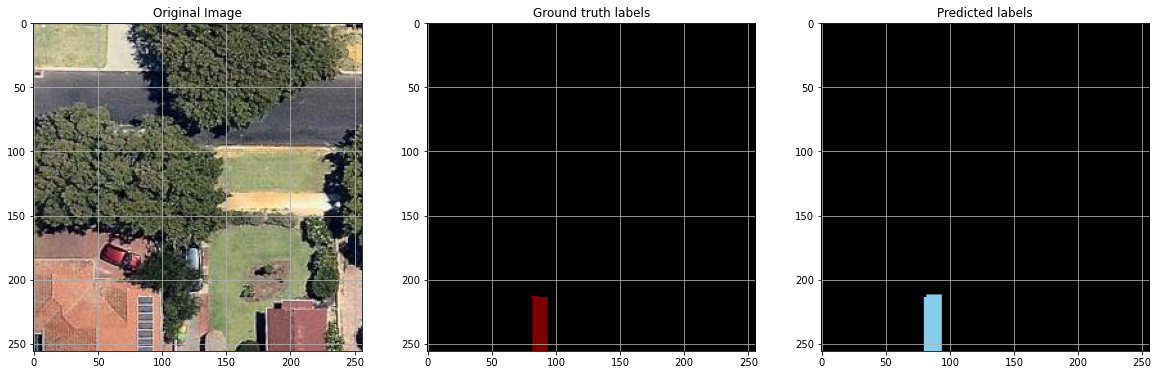

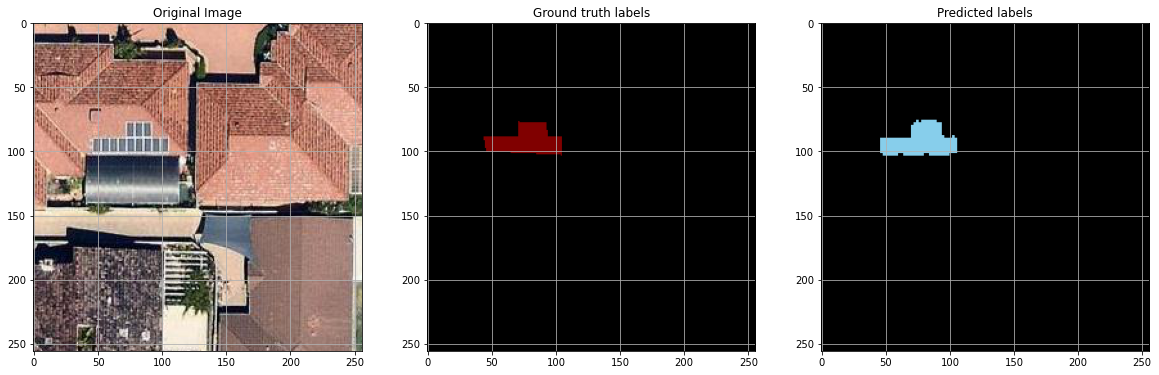

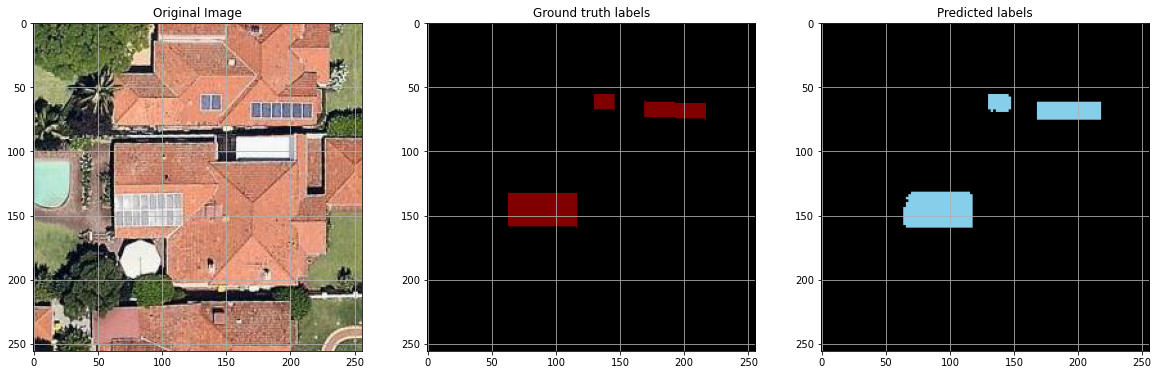

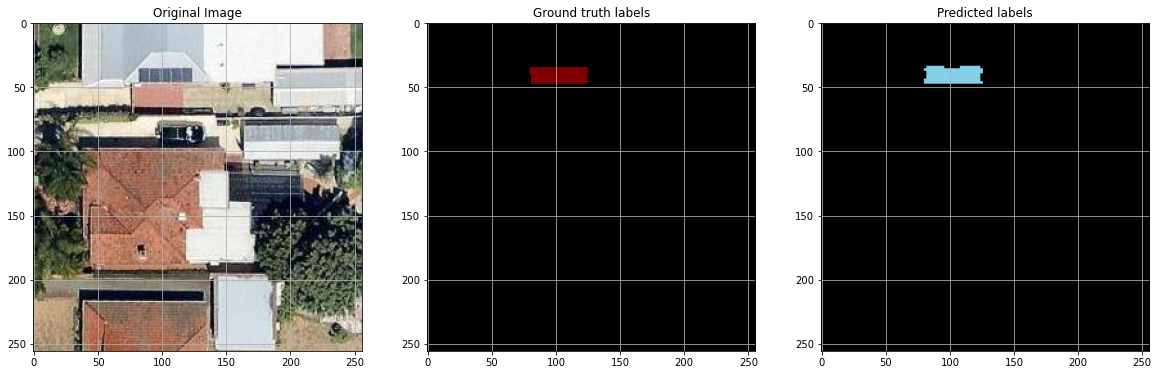

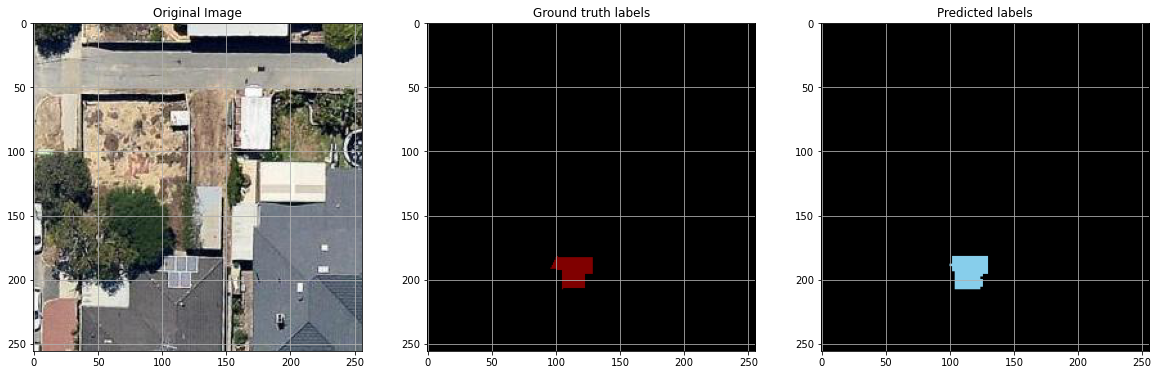

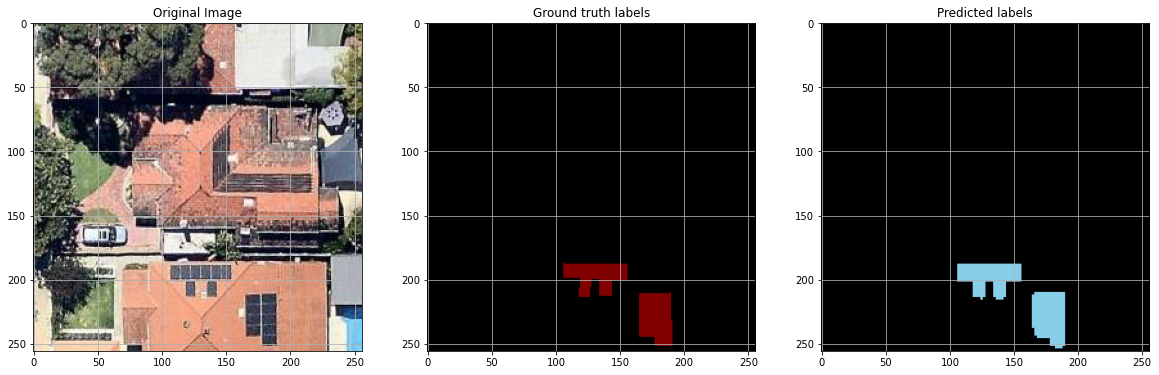

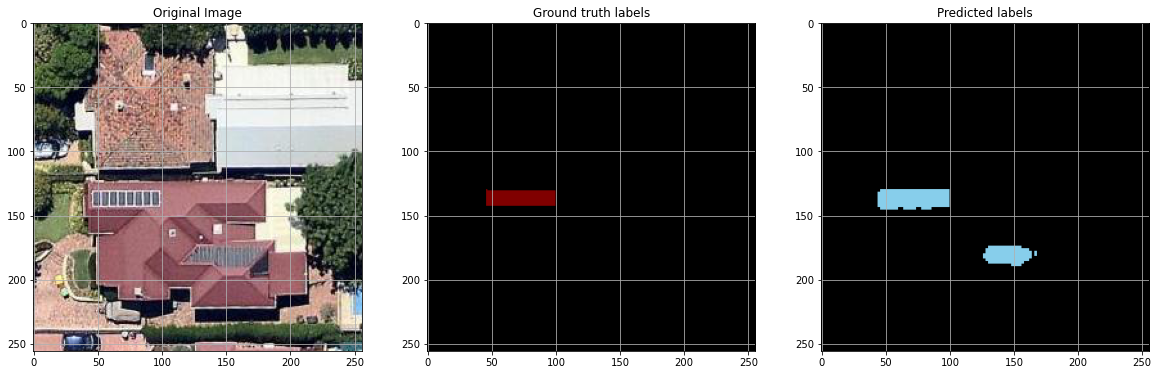

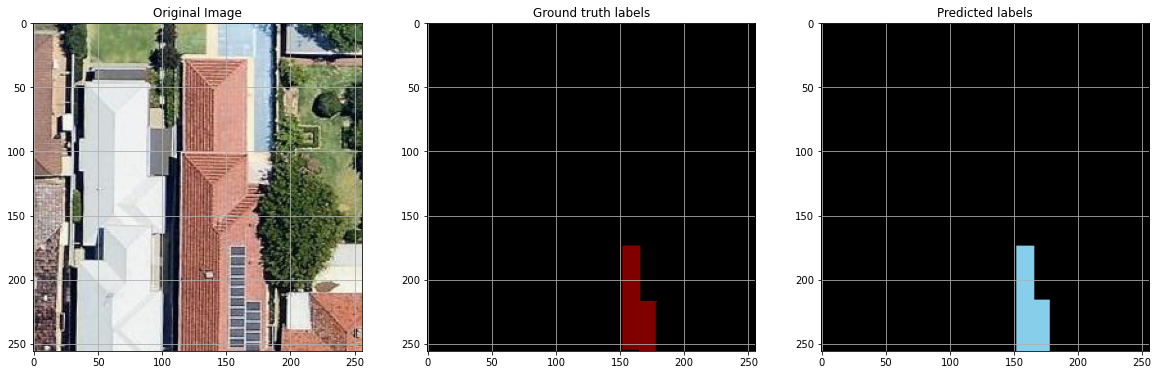

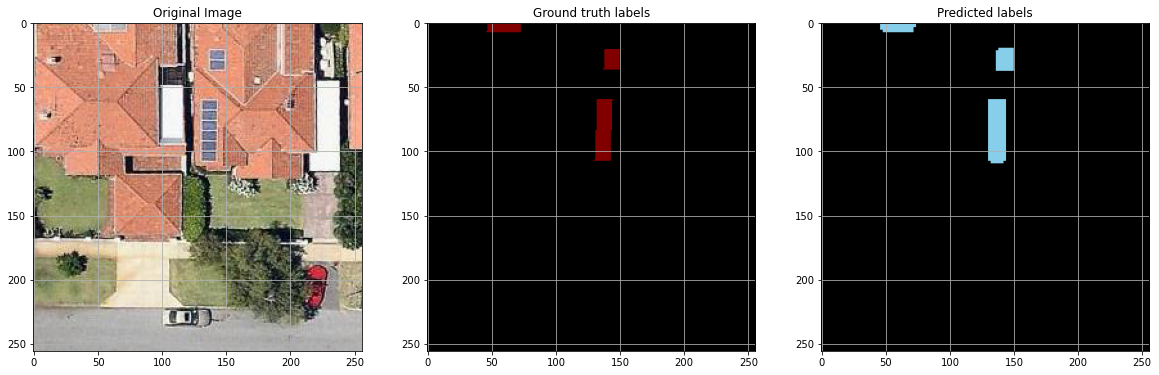

In [15]:
#84% val iou
fast_scnn.load_weights('trained_models/fast_scnn_2.h5')
testing_gen = prepare_data.test_data_generator(batch_size=16,seed=33)
#testing_gen=PrepareData.images_without_label_data_generator(batch_size=16)
flag=1
while(flag>0):
    flag=flag-1
    batch_img,batch_mask= next(testing_gen)
    #batch_img = next(testing_gen)
    pred_all = fast_scnn.predict(batch_img)
    np.shape(pred_all)
    for i in range(0, np.shape(pred_all)[0]):
        fig = plt.figure(figsize=(20, 8))

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(batch_img[i])
        ax1.title.set_text('Original Image')
        ax1.grid(b=None)

        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Ground truth labels')
        ax2.imshow(prepare_data.onehot_to_rgb(batch_mask[i], prepare_data.id2code))
        ax2.grid(b=None)

        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Predicted labels')
        #Use a different color for prediction
        new_color_code={0: (0, 0, 0), 1: (135,206,235)}
        ax3.imshow(prepare_data.onehot_to_rgb(pred_all[i], new_color_code))
        ax3.grid(b=None)
        plt.show()

In [ ]:
%tensorboard --logdir training_logs/fast_scnn_logs2